In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn import metrics

device = "cpu"
if torch.cuda.is_available():
  device = "cuda:0"

device

# Leer los datos
df = pd.read_csv('DataSet/colapso.csv')
df.set_index('Timestamp', inplace=True)
df["Colapso"] = df["Colapso"].apply(lambda q: 0 if q==1 else 1)
# Separar características y etiquetas
x = df.drop(['Colapso'], axis=1).values
y = df['Colapso'].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, stratify=df['Colapso'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.1, shuffle=True, stratify=y_train)

n_train = X_train.shape[0]
n_valid = X_val.shape[0]

# Definir la clase Dataset
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Crear DataLoader para entrenamiento y validación
train_ds = MyDataset(X_train, y_train)
valid_ds = MyDataset(X_val, y_val)

train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size=64)

# Definir la arquitectura de la red neuronal
class NNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(in_features=226, out_features=200)
        self.relu_1 = nn.ReLU()
        self.linear_2 = nn.Linear(in_features=200, out_features=100)
        self.relu_2 = nn.ReLU()
        self.output = nn.Linear(in_features=100, out_features=1)

    def forward(self, x):
        x = self.relu_1(self.linear_1(x))
        x = self.relu_2(self.linear_2(x))
        x = self.output(x)
        return x

# Crear instancia de la red neuronal
nnet = NNet()

# Definir función de pérdida y optimizador
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(nnet.parameters(), lr=0.001)

# Cantidad de epochs
epochs = 100
train_loss_history = []
valid_loss_history = []
train_recall_history = []
valid_recall_history = []

# cantidad de epochs
epochs = 100

train_loss_by_epoch=[]
valid_loss_by_epoch=[]

# Doble loop algoritmo Mini-Batch
for epoch in range(epochs):
  
  ############################################
  ## Entrenamiento
  ############################################
  nnet.train(True)

  epoch_loss = 0
  epoch_y_hat = []
  epoch_y = []
  
  for i,data in enumerate(train_dataloader):
    # Obtengo los datos del batch de entrenamiento
    x_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    # Paso forward
    # Limpio optimizer para empezar un nuevo cálculo de gradiente
    optimizer.zero_grad()
    nnet_output = nnet(x_batch)
    y_batch_hat = torch.sigmoid(nnet_output)
    
    # Calculo el loss
    loss = loss_function(nnet_output, y_batch)

    # Backpropagation
    loss.backward()

    # Actualizar los parámetros
    optimizer.step()

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    epoch_y += list(y_batch.detach().cpu().numpy())
    epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    epoch_loss = epoch_loss + loss.item()

  # Calculo la media de la loss
  epoch_loss = epoch_loss / n_train
  # Almaceno la loss de la epoch para graficar
  train_loss_by_epoch.append(epoch_loss)
  # Cálculo la métrica de la epoch
  recall = metrics.recall_score(epoch_y, [j>=0.5 for j in epoch_y_hat])

  train_recall_history.append(recall)
  ############################################
  ## Validación
  ############################################
  # Desactivo el cálculo de gradiente para validación
  nnet.train(False)

  valid_epoch_loss = 0
  valid_epoch_y_hat = []
  valid_epoch_y = []

  for i,data in enumerate(valid_dataloader):
    # Obtengo los datos del batch de validación
    x_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    # Paso forward
    nnet_output = nnet(x_batch)
    y_batch_hat = torch.sigmoid(nnet_output)
    
    # Calculo el loss
    loss = loss_function(nnet_output, y_batch)

    # En validación no hago backpropagation!!

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    valid_epoch_y += list(y_batch.detach().cpu().numpy())
    valid_epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    valid_epoch_loss = valid_epoch_loss + loss.item()

  # Calculo la media de la loss
  valid_epoch_loss = valid_epoch_loss / n_valid
  # Almaceno la loss de la epoch para graficar
  valid_loss_by_epoch.append(valid_epoch_loss)
  # Cálculo la métrica de la epoch
  valid_recall = metrics.recall_score(valid_epoch_y, [j>=0.5 for j in valid_epoch_y_hat])

  valid_recall_history.append(valid_recall)

  ############################################
  ## Impresión de resultados por epoch
  ############################################
  print(f" Epoch {epoch} | " \
        f"Train/Valid loss: {epoch_loss:.3f} / {valid_epoch_loss:.3f} | " \
        f"Train/Valid recall: {recall:.3f} / {valid_recall:.3f}")

 Epoch 0 | Train/Valid loss: 0.056 / 0.013 | Train/Valid recall: 0.559 / 0.732
 Epoch 1 | Train/Valid loss: 0.083 / 0.028 | Train/Valid recall: 0.542 / 0.047
 Epoch 2 | Train/Valid loss: 0.016 / 0.014 | Train/Valid recall: 0.527 / 0.295
 Epoch 3 | Train/Valid loss: 0.012 / 0.016 | Train/Valid recall: 0.616 / 0.987
 Epoch 4 | Train/Valid loss: 0.012 / 0.015 | Train/Valid recall: 0.643 / 0.980
 Epoch 5 | Train/Valid loss: 0.011 / 0.017 | Train/Valid recall: 0.691 / 0.107
 Epoch 6 | Train/Valid loss: 0.012 / 0.016 | Train/Valid recall: 0.605 / 0.074
 Epoch 7 | Train/Valid loss: 0.011 / 0.015 | Train/Valid recall: 0.646 / 0.987
 Epoch 8 | Train/Valid loss: 0.010 / 0.017 | Train/Valid recall: 0.715 / 1.000
 Epoch 9 | Train/Valid loss: 0.012 / 0.012 | Train/Valid recall: 0.670 / 0.383
 Epoch 10 | Train/Valid loss: 0.010 / 0.012 | Train/Valid recall: 0.692 / 0.718
 Epoch 11 | Train/Valid loss: 0.010 / 0.012 | Train/Valid recall: 0.709 / 0.940
 Epoch 12 | Train/Valid loss: 0.010 / 0.015 | Trai

Text(0, 0.5, 'BCE')

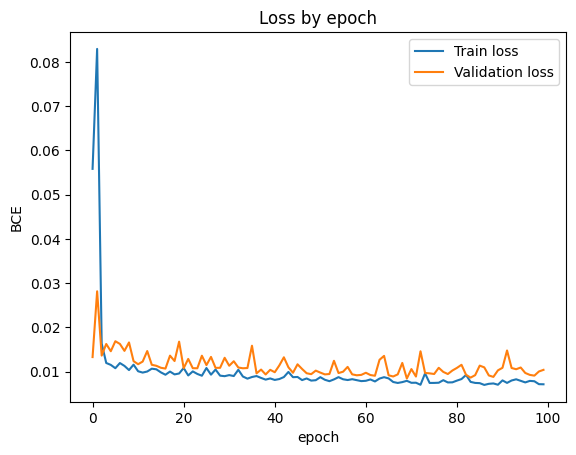

In [78]:
import matplotlib.pyplot as plt

# Grafica loss por epoch
fig, ax1= plt.subplots(1,1)
ax1.plot(train_loss_by_epoch, label="Train loss")
ax1.plot(valid_loss_by_epoch, label="Validation loss")
ax1.legend()
ax1.set_title("Loss by epoch")
ax1.set_xlabel("epoch")
ax1.set_ylabel("BCE")
     

Text(0, 0.5, 'BCE')

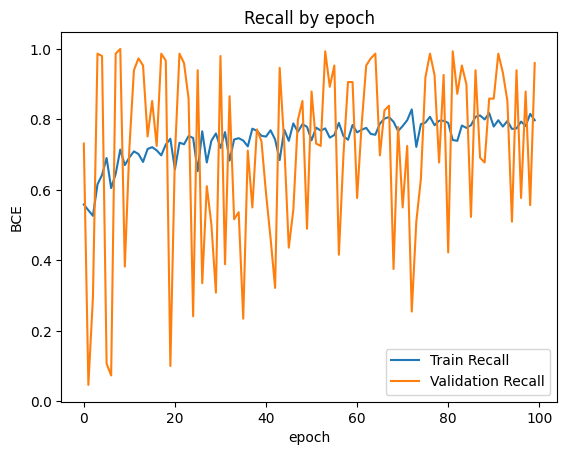

In [80]:
# Grafica loss por epoch
fig, ax1= plt.subplots(1,1)
ax1.plot(train_recall_history, label="Train Recall")
ax1.plot(valid_recall_history, label="Validation Recall")
ax1.legend()
ax1.set_title("Recall by epoch")
ax1.set_xlabel("epoch")
ax1.set_ylabel("BCE")